In [5]:
import configparser
config = configparser.ConfigParser()
config.read("../config.ini")

import pandas as pd

# Toy data using Cox and training the NLL

In [8]:
from lifelines.datasets import load_regression_dataset
df = load_regression_dataset()
df

,var1,var2,var3,T,E
0,0.595170,1.143472,1.571079,14.785652,1
1,0.209325,0.184677,0.356980,7.335846,1
2,0.693919,0.071893,0.557960,5.269797,1
3,0.443804,1.364646,0.374221,11.684092,1
4,1.613324,0.125566,1.921325,7.639492,1
...,...,...,...,...,...
195,0.137399,0.107748,0.354812,11.445457,1
196,0.637341,2.847188,1.459137,7.624627,1
197,1.109732,0.405561,0.018856,10.634620,1
198,0.031865,1.753759,0.252040,8.519718,1


In [9]:
from imblearn.over_sampling import SMOTE

# Applying SMOTE to balance the dataset
X = df[["var1", "var2", "var3", "T"]]
y = df["E"]

smote = SMOTE(random_state=123)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combining the resampled data into a new DataFrame
resampled_df = pd.DataFrame(X_resampled, columns=["var1", "var2", "var3", "T"])
resampled_df["E"] = y_resampled

In [12]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(resampled_df, test_size=0.2, random_state=123)
train_tensor = torch.tensor(train_df.values, dtype=torch.float32)

In [13]:


train_df, val_df = train_test_split(resampled_df, test_size=0.2, random_state=123)
train_tensor = torch.tensor(train_df.values, dtype=torch.float32)


X = train_tensor[:, :3]  
T = train_tensor[:, 3]  
E = train_tensor[:, 4] 

# Define a simple neural network
class DeepSurvivalModel(nn.Module):
    def __init__(self, input_dim):
        super(DeepSurvivalModel, self).__init__()
        self.hidden = nn.Linear(input_dim, 16)
        self.output = nn.Linear(16, 1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, training=True):
        x = torch.relu(self.hidden(x))
        if training:
            x = self.dropout(x)
        return self.output(x)

# Cox partial likelihood loss
def cox_partial_likelihood(risk_scores, times, events):
    indices = torch.argsort(times, descending=True)
    risk_scores = risk_scores[indices]
    events = events[indices]

    log_risk = torch.cumsum(torch.exp(risk_scores), dim=0).log()
    log_likelihood = (risk_scores - log_risk) * events
    return -log_likelihood.sum()

# C-Index evaluation
def c_index(risk_scores, times, events):
    order = torch.argsort(times)
    risk_scores, events = risk_scores[order], events[order]
    n = len(times)
    concordant, permissible = 0, 0
    for i in range(n):
        for j in range(i + 1, n):
            if events[j] == 1:  # Only compare if j experienced an event
                permissible += 1
                if risk_scores[i] < risk_scores[j]:
                    concordant += 1
    return concordant / permissible if permissible > 0 else 0.0



model = DeepSurvivalModel(input_dim=3)
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stop_patience = 5
best_c_index = 0
no_improve_epochs = 0



n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    risk_scores = model(X).squeeze()
    loss = cox_partial_likelihood(risk_scores, T, E)
    loss.backward()
    optimizer.step()


    model.eval()
    with torch.no_grad():
        risk_scores = model(X, training=False).squeeze()
        ci = c_index(risk_scores, T, E)

    print(f"epoch {epoch + 1}/{n_epochs}, Loss: {loss.item():.4f}, C-Index: {ci:.4f}")


    if ci > best_c_index:
        best_c_index = ci
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= early_stop_patience:
            print("early stopping")
            break


epoch 1/100, Loss: 714.1121, C-Index: 0.6313
epoch 2/100, Loss: 702.2926, C-Index: 0.6320
epoch 3/100, Loss: 708.0414, C-Index: 0.6317
epoch 4/100, Loss: 706.6443, C-Index: 0.6311
epoch 5/100, Loss: 706.6496, C-Index: 0.6315
epoch 6/100, Loss: 707.1624, C-Index: 0.6309
epoch 7/100, Loss: 708.0426, C-Index: 0.6300
early stopping


In [16]:
val_tensor = torch.tensor(val_df.values, dtype=torch.float32)

X_val = val_tensor[:, :3]  
T_val = val_tensor[:, 3]   
E_val = val_tensor[:, 4]  

model.eval()
with torch.no_grad():
    risk_scores_val = model(X_val, training=False).squeeze()
    loss_val = cox_partial_likelihood(risk_scores_val, T_val, E_val)
    ci_val = c_index(risk_scores_val, T_val, E_val)

print(f"Validation Loss: {loss_val.item():.4f}, Validation C-Index: {ci_val:.4f}")


Validation Loss: 123.9406, Validation C-Index: 0.6166


# Check proportional hazard assumption

<lifelines.CoxPHFitter: fitted with 267 total observations, 182 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 267
number of events observed = 85
   partial log-likelihood = -393.62
         time fit was run = 2025-01-31 17:03:07 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
gender        -0.08      0.92      0.23           -0.53            0.37                0.59                1.45
race           0.18      1.20      0.22           -0.25            0.62                0.78                1.86
age_diagnosis  0.00      1.00      0.00            0.00            0.00                1.00                1.00
ajcc_m         0.09      1.09      0.34           -0.58            0.75                0.56                2.12
ajcc_n        -0.05      0.95      0.11           -0.28            0.17                0.76                1.19
ajcc_stage     0.62      1.86      0.24            0.14            1.10                1.15                2.99
ajcc_t        -0.03      0.98      0.08           -0.19            0.14                0.83                1.15

               cmp to     z      p  -log2(p)
covariate                                   
gender           0.00 -0.36   0.72      0.47
race             0.00  0.83   0.41      1.30
age_diagnosis    0.00  3.41 <0.005     10.57
ajcc_m           0.00  0.26   0.80      0.33
ajcc_n           0.00 -0.44   0.66      0.61
ajcc_stage       0.00  2.54   0.01      6.48
ajcc_t           0.00 -0.30   0.76      0.39
---
Concordance = 0.75
Partial AIC = 801.24
log-likelihood ratio test = 58.20 on 7 df
-log2(p) of ll-ratio test = 31.43


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.9109)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9885)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3133)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1658)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9384)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5893)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2485)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1830)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2900)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2013)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1087)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1104)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7042)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9045)'>]]

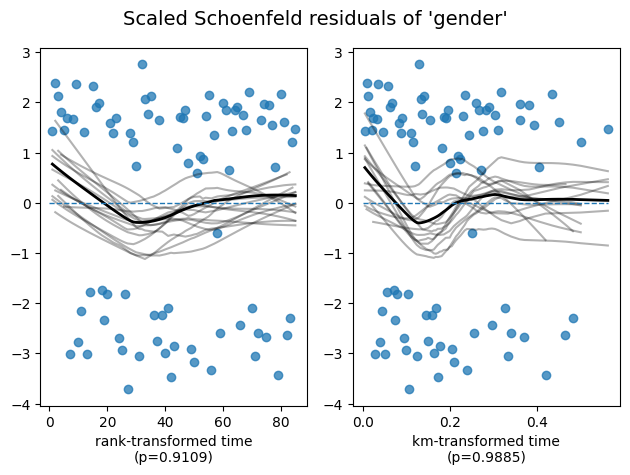

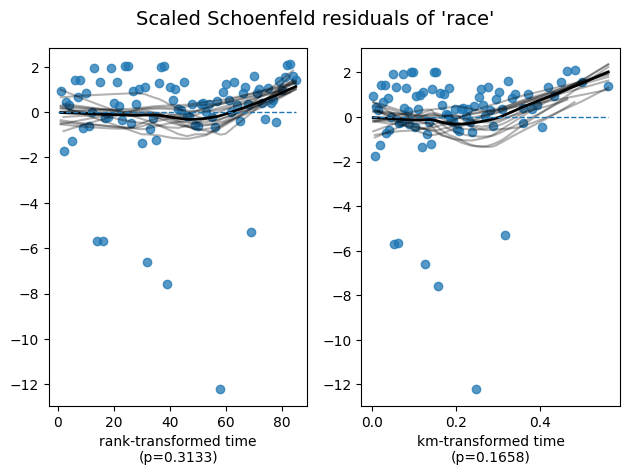

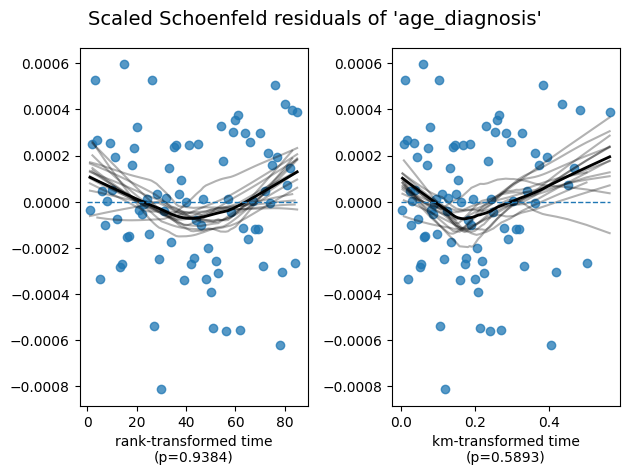

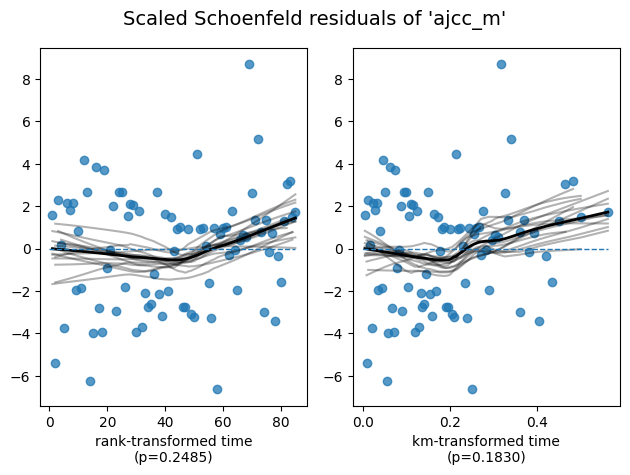

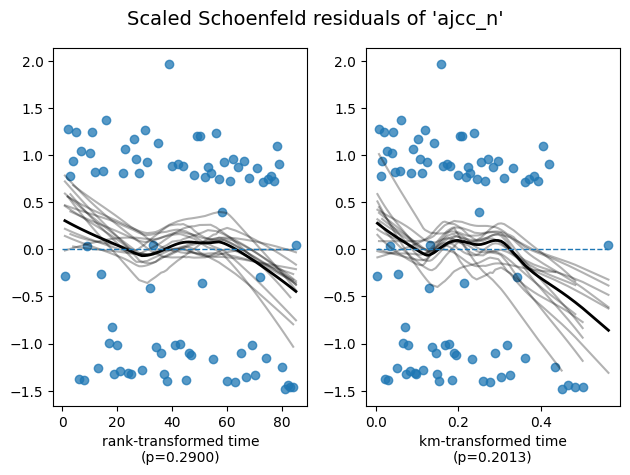

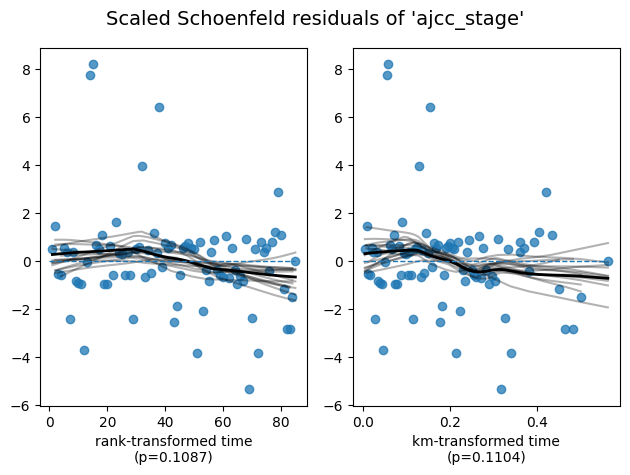

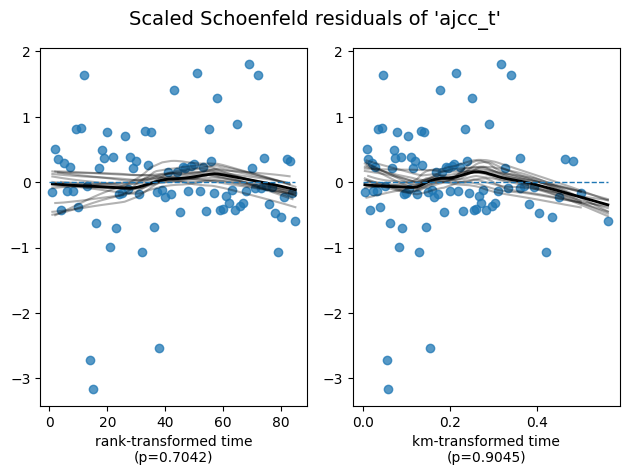

In [6]:
clinical_path_267 = config["clinical_path"]["cleaned_clinical_267"]
data_267 = pd.read_csv(clinical_path_267)
df_check_ph_assumption = data_267.drop(["id", "submitter_id"], axis=1)


from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(df_check_ph_assumption, duration_col='time', event_col='event')
cph.print_summary()  

cph.check_assumptions(df_check_ph_assumption, p_value_threshold=0.05, show_plots=True)